In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors  
import warnings
warnings.filterwarnings("ignore")

# Read Psychophysical Dataset

In [3]:
## Dravnieks
dravnieksdf = pd.read_csv("dravnieks/raw/DravnieksGrid.csv").iloc[:,1:] ## available dataset downloaded from pyrfume project
dravcid = pd.read_csv("dravnieks/raw/identifiers.csv")[["CID"]] ## retrieve cid information
dravsmile = pd.read_csv("dravnieks/raw/molecules.csv")[["IsomericSMILES"]] ## retrieve smiles information

# add retrieved information to our psychophysical dataset
dravnieksdf = pd.concat((dravcid, dravnieksdf), 1)
dravnieksdf.dropna(inplace=True)
dravnieksdf = dravnieksdf.set_index(np.arange(len(dravnieksdf)))
dravnieksdf = pd.concat((dravsmile, dravnieksdf), 1)

dravnieksdf.to_csv("dravnieks/raw/dravnieks_pa.csv")

In [4]:
## Reformat the Keller dataset from its raw version
from tqdm import tqdm
kellerdf = pd.read_csv("keller/raw/Keller_12868_2016_287_MOESM1_ESM.csv") ## available from original paper
kellerdf.columns = kellerdf.iloc[1,:]
kellerdf = kellerdf.iloc[2:,:]
kellerdf.fillna(0, inplace=True)

## we extract only columns of interest
kellerdf = kellerdf[['CID', 'Subject # (this study) ','HOW PLEASANT IS THE SMELL?','EDIBLE ', 'BAKERY ', 'SWEET ', 'FRUIT ',
       'FISH', 'GARLIC ', 'SPICES ', 'COLD', 'SOUR ', 'BURNT ', 'ACID ',
       'WARM ', 'MUSKY ', 'SWEATY ', 'AMMONIA/URINOUS', 'DECAYED', 'WOOD ',
       'GRASS ', 'FLOWER ', 'CHEMICAL']]

## we change some column name for easier reference
kellerdf.rename(columns={"HOW PLEASANT IS THE SMELL?": "PLEASANTNESS"}, inplace=True)
kellerdf = kellerdf.astype(float)

## from the Keller's paper, we know that 480 chemicals in total are tested 
assert len(kellerdf["CID"].unique())==480

## Calculate Percentage of Applicability

In [5]:

df_keller_pa = pd.DataFrame()
for cid in tqdm(kellerdf.CID.astype(int).unique()):
    tempdata = kellerdf[kellerdf["CID"]==cid].iloc[:,2:]
    tempPU = (np.average(tempdata>0, axis=0))
    tempPU = np.sum(tempdata, axis=0)/(100*len(tempdata))
    pa = np.sqrt(tempPU*tempPU)*100
    df_keller_pa = pd.concat((df_keller_pa, pa),1)

df_keller_pa = df_keller_pa.T
df_keller_pa.index = (kellerdf.CID.astype(int).unique())

df_keller_pa.to_csv("keller/raw/keller_pa.csv")

100%|██████████| 480/480 [00:01<00:00, 466.17it/s]


## Extract Overlapped Molecules

In [6]:
overlapcid = []
for cid in df_keller_pa.index.values:
    if cid in dravnieksdf["CID"].values:
        overlapcid+=[cid]

with open('overlapped.npy', 'wb') as f:
    np.save(f, np.array(overlapcid))

(len(overlapcid))

65

## Extract Semantically Matched Odor Descriptors

In [7]:
sharedescriptor = {"keller":[], "dravnieks":[]}
for des in df_keller_pa.columns.values:
    for desdrav in dravnieksdf.columns.values:
        if des == "CID" or desdrav=="CID":
            continue
        if des.strip() in desdrav or desdrav in des:
            sharedescriptor["dravnieks"]+=[desdrav]
            sharedescriptor["keller"]+=[des]

sharedescriptor = pd.DataFrame(sharedescriptor)
sharedescriptor

,keller,dravnieks
0,BAKERY,'BAKERY (FRESH BREAD)'
1,SWEET,'SWEET'
2,FRUIT,"'FRUITY,CITRUS'"
3,FRUIT,'GRAPEFRUIT'
4,FRUIT,"'FRUITY,OTHER THAN CITRUS'"
5,FRUIT,"'APPLE, FRUIT'"
6,FRUIT,'PEACH FRUIT'
7,FRUIT,"'FERMENTED, ROTTEN FRUIT'"
8,FISH,'FISHY'
9,FISH,"'KIPPERY,SMOKED FISH'"


## Correlation Analysis of PA on overlapping chemicals

In [8]:
## there are some repetition in dravnieks dataset, we now filter them out
cid_uniq = []
cid_repeat = []
for cid in dravnieksdf["CID"].values:
    if cid not in cid_uniq:
        cid_uniq+=[cid]
    else:
        cid_repeat+=[cid]

len(cid_repeat)

6

In [9]:
kellerovlp = pd.DataFrame()
dravovlp = pd.DataFrame()
for cid in overlapcid:
    dravovlp = pd.concat((dravovlp, dravnieksdf[dravnieksdf["CID"]==cid]),0)
    kellerovlp = pd.concat((kellerovlp, df_keller_pa[df_keller_pa.index==cid]),0)

## remove repeated cid in overlapped chemical cid set
dravovlp = dravovlp[dravovlp.CID.isin(cid_repeat)==False]
kellerovlp = kellerovlp[kellerovlp.index.isin(cid_repeat)==False]

## reformat to obtain a pure psychophysical data matrix
dravovlp.index = dravovlp.CID
dravovlp = dravovlp.iloc[:,2:]
dravovlp.shape

(61, 146)

In [11]:
import matplotlib.pyplot as plt
from scipy.spatial.distance import cosine

corrdis = np.zeros(len(sharedescriptor))
cosdis = np.zeros(len(sharedescriptor))
for i in range(len(sharedescriptor)):
    des = (sharedescriptor.iloc[i,:].values[0])
    dravdes = (sharedescriptor.iloc[i,:].values[1])
    corrdis[i] = np.corrcoef(dravovlp[dravdes], kellerovlp[des])[0,1]

sharedescriptor["corr"] = corrdis
sharedescriptor[sharedescriptor["corr"]>0.5]

,keller,dravnieks,corr
0,BAKERY,'BAKERY (FRESH BREAD)',0.678056
1,SWEET,'SWEET',0.829146
2,FRUIT,"'FRUITY,CITRUS'",0.563910
4,FRUIT,"'FRUITY,OTHER THAN CITRUS'",0.890124
6,FRUIT,'PEACH FRUIT',0.814849
10,GARLIC,"'GARLIC, ONION'",0.678773
11,SOUR,'SOUR MILK',0.823608
12,SOUR,"'SOUR, VINEGAR'",0.795024
20,SWEATY,'SWEATY',0.731716
21,DECAYED,"'PUTRID, FOUL, DECAYED'",0.781773


<AxesSubplot: >

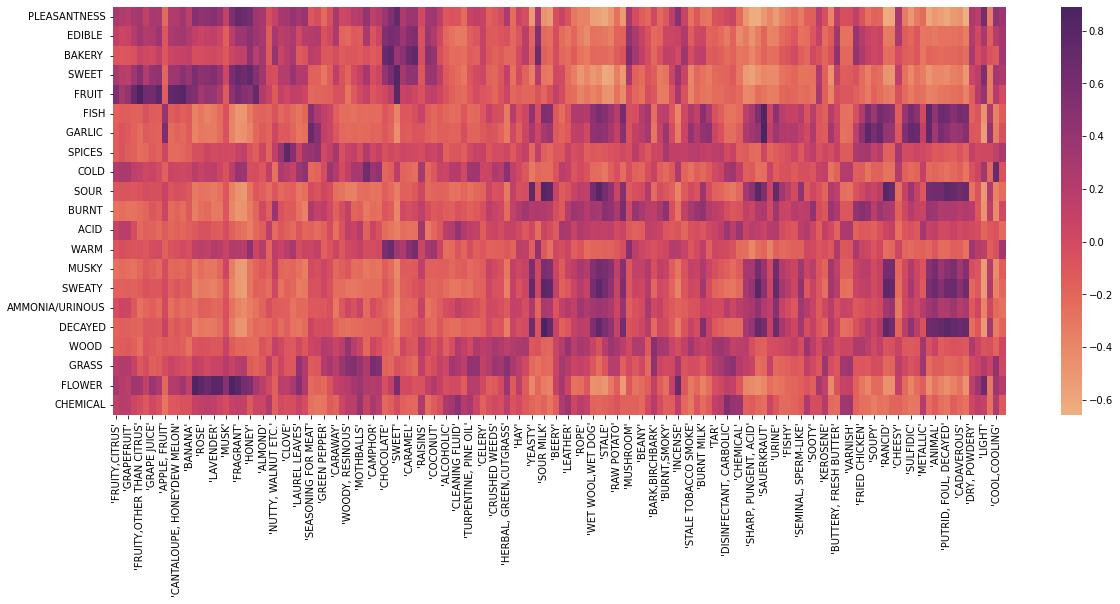

In [12]:
import seaborn as sns
corrdis_ = np.zeros((len(kellerovlp.columns), len(dravovlp.columns)))
for i in range(len(kellerovlp.columns)):
    for j in range(len(dravovlp.columns)):
        corrdis_[i,j] = np.corrcoef(kellerovlp.iloc[:,i].values, dravovlp.iloc[:, j].values)[0,1]
fig, ax = plt.subplots(figsize=(20,7.5))
corrdis_ = pd.DataFrame(corrdis_, columns=dravovlp.columns, index= kellerovlp.columns)

sns.heatmap(corrdis_, cmap="flare", ax=ax)

# Exploratory study for selected labels

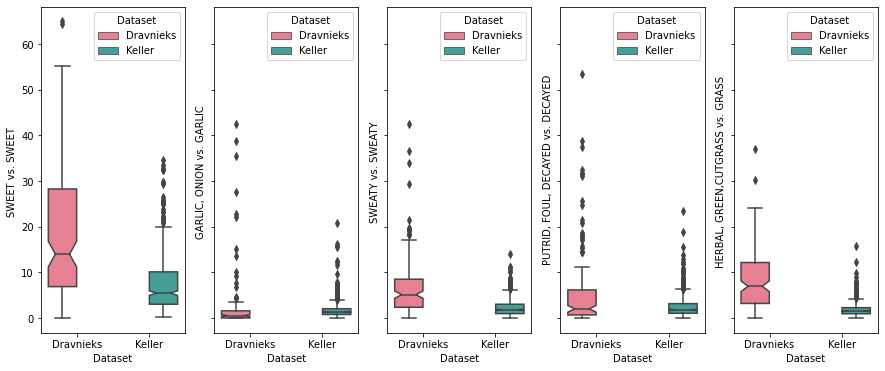

In [13]:
## Validate odor descriptor choice on the entire dataset
dravlabel = [ "'SWEET'", "'GARLIC, ONION'", "'SWEATY'", "'PUTRID, FOUL, DECAYED'","'HERBAL, GREEN,CUTGRASS'"]
kellerlabel = ["SWEET ", "GARLIC ", "SWEATY ", "DECAYED", "GRASS "]
labelpair = []
for i, _ in enumerate(dravlabel):
    labelpair+= [dravlabel[i].replace("'","")+" vs. "+kellerlabel[i]]

## Create a boxplot for distribution of PAs
dfplot = pd.DataFrame(np.concatenate((dravnieksdf[dravlabel].to_numpy(),df_keller_pa[kellerlabel].to_numpy()),0), columns = labelpair)
dfplot["Dataset"] = np.repeat("Dravnieks", len(dravnieksdf)).tolist()+np.repeat("Keller", len(df_keller_pa)).tolist()

fig, ax = plt.subplots(1, 5, figsize=(15,6), sharey=True)
for i in range(len(labelpair)): 
    sns.boxplot(data=dfplot, x="Dataset", y=labelpair[i], hue="Dataset", ax=ax[i], notch=True,palette = "husl")

fig.savefig("../Figs/paper_figs/OdorDescriptorPairs.png")

## Molecular Descriptors

In [14]:
from rdkit import Chem
from mordred import Calculator, descriptors

## Get started with Dravnieks dataset
data_descriptor = []
smilesall = dravnieksdf["IsomericSMILES"].to_numpy()
calc = Calculator(descriptors)
for smile in tqdm(smilesall):
    mol = Chem.MolFromSmiles(smile)
    calc_result = calc(mol)
    dict_result = calc_result.asdict()
    data_descriptor.append(dict_result)
dravmol = pd.DataFrame(data_descriptor)
dravmol.insert(0,"IsomericSMILES",Smiles)
dravmol.insert(0,"CID",dravnieksdf["CID"].to_numpy().astype(int))
dravmol.to_csv("dravnieks/raw/molecular_descriptors.csv")
dravmol.head()

100%|██████████| 144/144 [00:54<00:00,  2.66it/s]


,CID,IsomericSMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,61199,CCC1C(=C(C(=O)O1)O)C,7.277917,7.572649,0,0,12.259734,2.369191,4.484543,12.259734,...,9.034915,53.897700,142.062994,7.103150,111,13,48.0,56.0,4.944444,2.333333
1,7410,CC(=O)C1=CC=CC=C1,6.542301,6.236096,0,0,11.189957,2.193993,4.387987,11.189957,...,8.590258,37.289972,120.057515,7.062207,88,9,40.0,43.0,3.472222,2.111111
2,14286,CC(=O)C1=CC=CC=N1,6.542301,6.236096,0,0,11.189957,2.193993,4.387987,11.189957,...,8.590258,37.289972,121.052764,7.565798,88,9,40.0,43.0,3.472222,2.111111
3,98403,CC(CCCC(C)C=O)CCC=C(C)C,10.337054,9.696190,0,0,17.150665,2.084407,4.168814,17.150665,...,8.560061,44.474951,210.198365,5.126789,484,14,60.0,60.0,7.083333,3.666667
4,6501,CCOC(=O)C1C(O1)(C)C2=CC=CC=C2,11.418358,11.153296,0,0,19.171456,2.585211,4.841074,19.171456,...,9.849718,68.142058,206.094294,7.106700,378,20,78.0,94.0,5.395833,3.402778


In [20]:
import pubchempy as pcp

## Keller's dataset needs special handling since no smiles information is available online
smilesall,data_descriptor = [], []
kellercid = (df_keller_pa.index)

for cid in tqdm(kellercid):
    cps = pcp.Compound.from_cid(cid)
    smile = (cps.isomeric_smiles)
    smilesall +=[smile]
    mol = Chem.MolFromSmiles(smile)
    calc_result = calc(mol)
    dict_result = calc_result.asdict()
    data_descriptor.append(dict_result)
kellermol = pd.DataFrame(data_descriptor)
kellermol.insert(0,"IsomericSMILES",smilesall)
kellermol.insert(0,"CID",kellercid.to_numpy().astype(int))
kellermol.to_csv("keller/raw/molecular_descriptors.csv")
kellermol.head()

100%|██████████| 480/480 [04:18<00:00,  1.86it/s]


,CID,IsomericSMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,SpDiam_A,SpAD_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,16741,C1=CC=C(C=C1)CCN=C=S,7.778175,7.057066,0,0,13.98336,2.156639,4.313279,13.98336,...,8.491465,39.504541,163.045570,8.152279,182,10,46.0,48.0,3.361111,2.750000
1,17121,CCCCCC(C=C)OC(=O)C,7.996954,8.097782,0,0,13.776947,2.111991,4.223981,13.776947,...,8.326759,40.188740,170.130680,5.671023,237,11,46.0,46.0,5.722222,3.083333
2,520191,CC1=CC(=C(S1)C)C(=O)C,7.427747,7.567246,0,0,11.531561,2.33558,4.47489,11.531561,...,8.936035,53.391630,154.045236,7.702262,113,11,48.0,54.0,4.944444,2.222222
3,92979,C[C@]12CC[C@H]3[C@H]([C@@H]1CC=C2)CCC4=CC(=O)C...,16.424974,13.265580,0,0,26.293187,2.594028,5.160368,26.293187,...,10.459870,69.126315,270.198365,5.873878,699,40,120.0,151.0,6.180556,4.097222
4,62580,CC(C)C(=O)OCC1=CC2=C(C=C1)OCO2,12.268104,10.804121,0,0,20.304899,2.36631,4.645861,20.304899,...,9.452109,61.596833,222.089209,7.402974,481,20,80.0,91.0,5.555556,3.555556


## Missing Data Imputation

In [26]:
## Dravnieks
count_errorD={}

# ensure every entry has an numeric value, otherwise set to NA
for i in tqdm(range(len(dravmol.iloc[:,2:].columns))):
    ind = i+2
    count_errorD[str(ind)]=0
    for j in range(len(dravmol)):
        if float(dravmol.iloc[j,ind])>0 or float(dravmol.iloc[j,ind])<=0: 
            pass
        else:
            dravmol.iloc[j,ind] = np.nan
            count_errorD[str(ind)]+=1

count_errorD = pd.DataFrame(count_errorD, index=range(1))

100%|██████████| 1826/1826 [00:08<00:00, 221.72it/s]


In [27]:
count_errorK = {}
for i in tqdm(range(len(kellermol.iloc[:,2:].columns))):
    ind = i+2
    count_errorK[str(ind)]=0
    for j in range(len(kellermol)):
        if float(kellermol.iloc[j,ind])>0 or float(kellermol.iloc[j,ind])<=0:
            pass
        else:
            kellermol.iloc[j,ind] = np.nan
            count_errorK[str(ind)]+=1
            
count_errorK = pd.DataFrame(count_errorK, index=range(1))

100%|██████████| 1826/1826 [00:27<00:00, 65.93it/s] 


Text(0.5, 0, 'Ratio of the number of NA values to the number total chemicals')

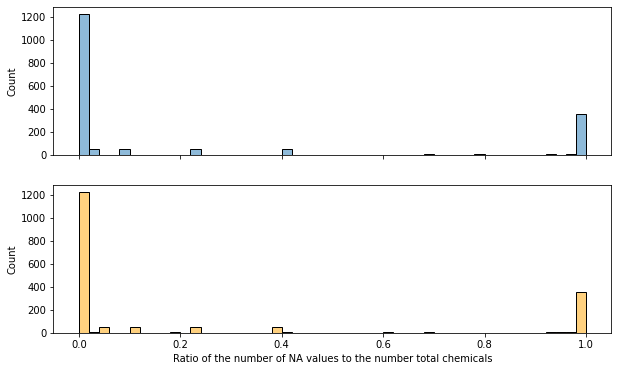

In [37]:
temp = pd.concat((count_errorD/len(dravmol), count_errorK/len(kellermol)),0)
temp.index=range(2)

import seaborn as sns
fig, ax = plt.subplots(2,figsize=(10,6), sharex=True, sharey=True)
sns.histplot(temp.loc[0], bins=50, alpha=.5, ax=ax[0])
sns.histplot(temp.loc[1], bins=50, alpha=.5, color="orange", ax=ax[1])
# ax.legend(["Dravnieks's Atlas of Odor Profile", "Keller pyschophysical datasets"])
ax[1].set_xlabel("Ratio of the number of NA values to the number total chemicals")
# fig.savefig("NA_values_mol_desc.png")

In [61]:
## filter out descriptors with >10% NA values across chemicals
items = list(set(dravmol.columns[2:][count_errorD.loc[0].values>.1]).union(set(dravmol.columns[2:][count_errorK.loc[0].values>.1])))
## retained descriptors
items_retained = (set(dravmol.iloc[:,2:].columns).difference(set(items)))

len(items_retained)

804

In [90]:
## Understand 
cols = list(items_retained)
dravfeat = dravmol[cols]
print(dravfeat.isna().sum().sum())

kellerfeat = kellermol[cols]
print(kellerfeat.isna().sum().sum())

0
0


In [104]:
from collinearity import SelectNonCollinear
selector = SelectNonCollinear(.5)
dravfeat_new = selector.fit_transform(dravfeat.astype(float).to_numpy())
kellerfeat_new = selector.fit_transform(kellerfeat.astype(float).to_numpy())

In [105]:
colall = list(items_retained)[2:]
retaineddravnisk = []
for i in range(dravfeat_new.shape[1]):
    for j in range(len(colall)):
        if np.sum(np.abs(dravfeat[colall[j]].values-dravfeat_new[:,i]))==0:
            retaineddravnisk+=[colall[j]]
print(len(retaineddravnisk))

retainedkeller = []
for i in range(kellerfeat_new.shape[1]):
    for j in range(len(colall)):
        if np.sum(np.abs(kellerfeat[colall[j]].values-kellerfeat_new[:,i]))==0:
            retainedkeller+=[colall[j]]
print(len(retainedkeller))

82
100


In [106]:
## Ensure the same set of input feature to enable transfer learning
retained = list(set(retaineddravnisk).intersection(retainedkeller))
print(len(retained))

54


In [107]:
## save the latex-friendly descriptor list
file = open("retained_descriptor.txt","w+")
for i, cols in enumerate(list(retained)):
  if (i+1)%5==0:
    file.write(cols+"\\\\\n")
  else:
    file.write(cols+"&")
file.close()

In [108]:
## save retained descriptor for easier retrievation
with open('retained_descriptors.npy', 'wb') as f:
    np.save(f, np.array(retained))

In [116]:
## save the final set of features
cols = ["CID", "IsomericSMILES"]+ retained
dravmol[cols].to_csv("dravnieks/raw/descriptors.csv")
kellermol[cols].to_csv("keller/raw/descriptors.csv")